In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import norm
from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [2]:
# Data Loaded into dataframe
data = pd.read_csv("/content/drive/MyDrive/CM3070 Final Year Project/nvda_2020_2022.csv")

<ipython-input-2-28e8c1ac27f1>:2: DtypeWarning: Columns (8,9,10,11,12,15,17,18,20,21,23,24,25,26,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("/content/drive/MyDrive/CM3070 Final Year Project/nvda_2020_2022.csv")


In [3]:
# Print dataset information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048761 entries, 0 to 1048760
Data columns (total 33 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   [QUOTE_UNIXTIME]        1048761 non-null  int64  
 1    [QUOTE_READTIME]       1048761 non-null  object 
 2    [QUOTE_DATE]           1048761 non-null  object 
 3    [QUOTE_TIME_HOURS]     1048761 non-null  float64
 4    [UNDERLYING_LAST]      1048761 non-null  float64
 5    [EXPIRE_DATE]          1048761 non-null  object 
 6    [EXPIRE_UNIX]          1048761 non-null  int64  
 7    [DTE]                  1048761 non-null  float64
 8    [C_DELTA]              1048761 non-null  object 
 9    [C_GAMMA]              1048761 non-null  object 
 10   [C_VEGA]               1048761 non-null  object 
 11   [C_THETA]              1048761 non-null  object 
 12   [C_RHO]                1048761 non-null  object 
 13   [C_IV]                 1048761 non-null  object 
 14   [

In [4]:
# Rename the columns
data.rename(columns=lambda x: x.replace('[', '').replace(']', '').strip(), inplace=True)

In [5]:
data.head()

,QUOTE_UNIXTIME,QUOTE_READTIME,QUOTE_DATE,QUOTE_TIME_HOURS,UNDERLYING_LAST,EXPIRE_DATE,EXPIRE_UNIX,DTE,C_DELTA,C_GAMMA,...,P_LAST,P_DELTA,P_GAMMA,P_VEGA,P_THETA,P_RHO,P_IV,P_VOLUME,STRIKE_DISTANCE,STRIKE_DISTANCE_PCT
0,1635796800,2021-11-01 16:00,2021-11-01,16.0,258.34,2021-11-05,1636142400,4.0,0.99833,0.00007,...,0.03,-0.00009,0.00001,0.00086,-0.00851,0.0,2.636460,1.000000,158.3,0.613
1,1635796800,2021-11-01 16:00,2021-11-01,16.0,258.34,2021-11-05,1636142400,4.0,0.99739,0.00003,...,0.03,-0.00033,-0.00002,0.00015,-0.00803,0.0,2.511730,2.000000,153.3,0.594
2,1635796800,2021-11-01 16:00,2021-11-01,16.0,258.34,2021-11-05,1636142400,4.0,0.99817,0.00004,...,0.14,-0.00088,-0.00002,0.00023,-0.00841,-0.00035,2.381360,10.000000,148.3,0.574
3,1635796800,2021-11-01 16:00,2021-11-01,16.0,258.34,2021-11-05,1636142400,4.0,1.0,0.0,...,0.0,-0.00074,-0.00001,0.00079,-0.00807,0.0,2.262370,,143.3,0.555
4,1635796800,2021-11-01 16:00,2021-11-01,16.0,258.34,2021-11-05,1636142400,4.0,1.0,0.0,...,0.04,-0.00004,0.00006,-0.00007,-0.00414,0.0,2.037550,20.000000,138.3,0.535


In [6]:
# Print the column names
data.columns

Index(['QUOTE_UNIXTIME', 'QUOTE_READTIME', 'QUOTE_DATE', 'QUOTE_TIME_HOURS',
       'UNDERLYING_LAST', 'EXPIRE_DATE', 'EXPIRE_UNIX', 'DTE', 'C_DELTA',
       'C_GAMMA', 'C_VEGA', 'C_THETA', 'C_RHO', 'C_IV', 'C_VOLUME', 'C_LAST',
       'C_SIZE', 'C_BID', 'C_ASK', 'STRIKE', 'P_BID', 'P_ASK', 'P_SIZE',
       'P_LAST', 'P_DELTA', 'P_GAMMA', 'P_VEGA', 'P_THETA', 'P_RHO', 'P_IV',
       'P_VOLUME', 'STRIKE_DISTANCE', 'STRIKE_DISTANCE_PCT'],
      dtype='object')

In [7]:
# Convert the column to date time
data['QUOTE_READTIME'] = pd.to_datetime(data['QUOTE_READTIME'])
# Convert the columns to float
numeric_columns = ['UNDERLYING_LAST', 'STRIKE', 'DTE', 'C_IV','C_LAST']
data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')

In [8]:
# Print the first date of data
data['QUOTE_READTIME'].min()

Timestamp('2020-01-02 16:00:00')

In [9]:
data.info()
# The C_IV Column has null rows after converting as a result the rows were dropped
data.dropna(inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048761 entries, 0 to 1048760
Data columns (total 33 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   QUOTE_UNIXTIME       1048761 non-null  int64         
 1   QUOTE_READTIME       1048761 non-null  datetime64[ns]
 2   QUOTE_DATE           1048761 non-null  object        
 3   QUOTE_TIME_HOURS     1048761 non-null  float64       
 4   UNDERLYING_LAST      1048761 non-null  float64       
 5   EXPIRE_DATE          1048761 non-null  object        
 6   EXPIRE_UNIX          1048761 non-null  int64         
 7   DTE                  1048761 non-null  float64       
 8   C_DELTA              1048761 non-null  object        
 9   C_GAMMA              1048761 non-null  object        
 10  C_VEGA               1048761 non-null  object        
 11  C_THETA              1048761 non-null  object        
 12  C_RHO                1048761 non-null  object        
 1

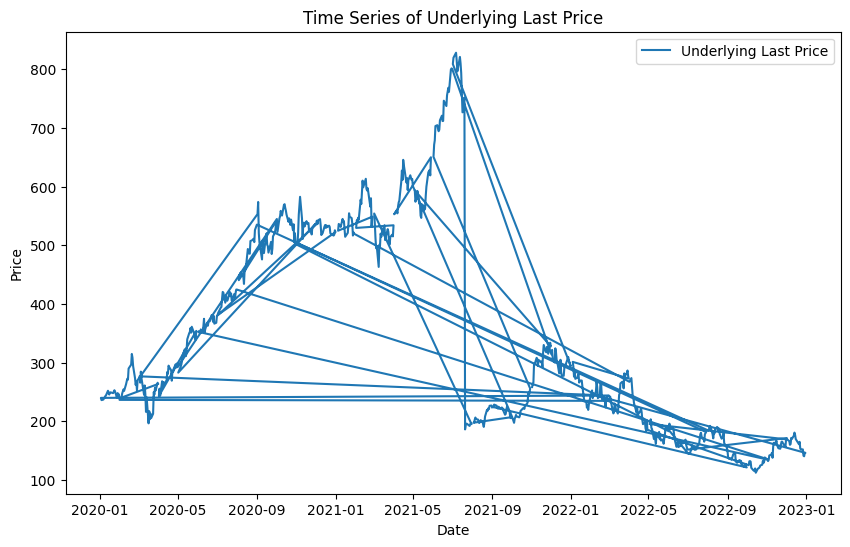

In [10]:
# Time-series plot of Underlying Last Price
plt.figure(figsize=(10,6))
plt.plot(data['QUOTE_READTIME'], data['UNDERLYING_LAST'], label='Underlying Last Price')
plt.title('Time Series of Underlying Last Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

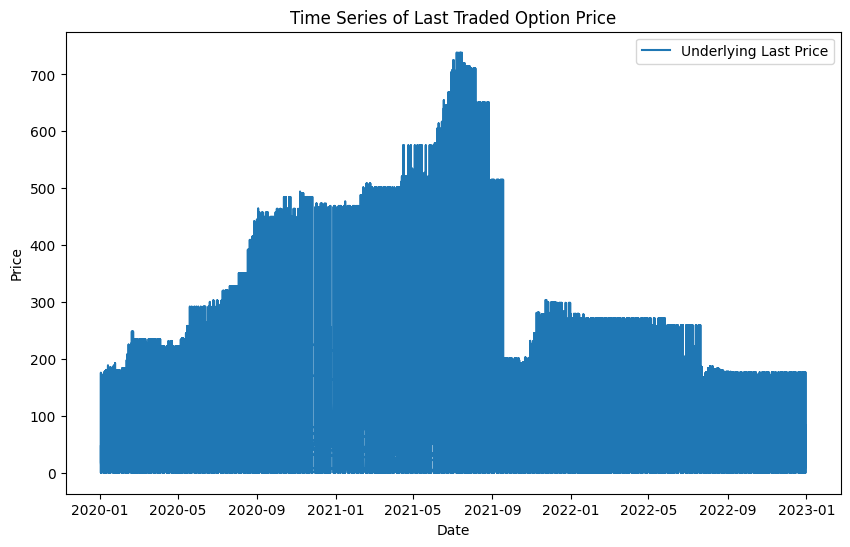

In [11]:
# Time-series plot of Underlying Last Price
plt.figure(figsize=(10,6))
plt.plot(data['QUOTE_READTIME'], data['C_LAST'], label='Underlying Last Price')
plt.title('Time Series of Last Traded Option Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [12]:
# Filter data only for the first month
month = 1
year = 2021
filtered_data = data[(data['QUOTE_READTIME'].dt.month == month) & (data['QUOTE_READTIME'].dt.year == year)]
len(filtered_data)

23072

In [13]:
# Function to calculate Black-Scholes option prices and return as an array
def black_scholes_array(data, r=0.02, option_type='call'):
  option_prices = []
  # Iterate over each row
  for index, row in data.iterrows():
    # Current Stock Price
    S = row['UNDERLYING_LAST']
    # Option Strike Price
    K = row['STRIKE']
    # Time to expiration in years
    T = row['DTE'] / 365.0
    # Implied volatility
    sigma = row['C_IV']

    # Calculate the D1 & D2 for Black Scholes formula
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    # Calculate the option price based on the type of the option
    if option_type == 'call':
      # Call Option price
      option_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
      # Put Option Price
      option_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
      # Raise an error if option type is incorrect
      raise ValueError("Option type must be 'call' or 'put'")

    # Append the calculated price to the list
    option_prices.append(option_price)

  # Return the list of option prices as an array
  return np.array(option_prices)

In [14]:
# Calculate option prices for each row in the DataFrame
bs_option_prices = black_scholes_array(filtered_data)

<ipython-input-13-d1b60d7036d5>:16: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


In [15]:
# Calculate the MAE as the last traded price
mae_last = mean_absolute_error(filtered_data['C_LAST'], bs_option_prices)
# Calculate the RMSE using the last trade price
rmse_last = np.sqrt(mean_squared_error(filtered_data['C_LAST'], bs_option_prices))
# Print the calculated MAE & RMSE Values
print(f"MAE (Last Price): {mae_last:.2f}, RMSE (Last Price): {rmse_last:.2f}")

MAE (Last Price): 27.25, RMSE (Last Price): 67.58


In [16]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Normalize the features using the StandardScaler
filtered_data[['UNDERLYING_LAST', 'STRIKE', 'DTE', 'C_IV']] = scaler.fit_transform(filtered_data[['UNDERLYING_LAST', 'STRIKE', 'DTE', 'C_IV']])
# X consists of the scaled features
X = filtered_data[['UNDERLYING_LAST', 'STRIKE', 'DTE', 'C_IV']].values
# y consists of the target variable
y = filtered_data['C_LAST'].values

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

<ipython-input-16-ecdcfd186c60>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[['UNDERLYING_LAST', 'STRIKE', 'DTE', 'C_IV']] = scaler.fit_transform(filtered_data[['UNDERLYING_LAST', 'STRIKE', 'DTE', 'C_IV']])


In [17]:
# Model 1: Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)

In [18]:
# Model 2: XGBoost
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_val)

In [19]:
# Model 3: Support Vector Regressor
svr = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr.fit(X_train, y_train)
y_pred_svr = svr.predict(X_val)


In [20]:
# Model 4: Standard Deep Learning Model (Feedforward Neural Network)
model_nn = Sequential([
      Dense(64, activation='relu', input_shape=(X_train.shape[1],)), # First Layer
      Dense(32, activation='relu'), # Second Layer
      Dense(1)  # Output layer
  ])

model_nn.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])
history_nn = model_nn.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_val, y_val), verbose=1)
y_pred_nn = model_nn.predict(X_val)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1154/1154 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 11293.6475 - mae: 62.3901 - val_loss: 3184.5273 - val_mae: 34.3336
Epoch 2/50
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 3129.0820 - mae: 33.8667 - val_loss: 3016.5620 - val_mae: 33.0467
Epoch 3/50
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 3082.7732 - mae: 32.4119 - val_loss: 2860.5735 - val_mae: 31.5339
Epoch 4/50
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 2747.7498 - mae: 29.7899 - val_loss: 2757.8816 - val_mae: 30.8584
Epoch 5/50
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2721.2944 - mae: 29.7751 - val_loss: 2693.5654 - val_mae: 30.4685
Epoch 6/50
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2601.1809 - mae: 29.0770 - val_loss: 2649.2305 - val_mae: 29.1130
Epoch 7/50
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 2592.4290 - mae: 28.6644 - val_loss: 2611.7249 - val_mae: 29.6119
Epoch 8/50
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2490.9875 - mae: 28.2143 - val_loss: 2627.5032 - val

In [21]:
# Model 5: Deep Learning with LSTM
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_lstm = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

model_lstm = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)), # First Layer
    Dropout(0.2), # Dropout Layer
    LSTM(32, return_sequences=False), # Second Layer
    Dropout(0.2), # Dropout Layer
    Dense(1) # Output Layer
])

model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])
history_lstm = model_lstm.fit(X_train_lstm, y_train, epochs=50, batch_size=16, validation_data=(X_val_lstm, y_val), verbose=1)
y_pred_lstm = model_lstm.predict(X_val_lstm)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1154/1154 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 17782.1426 - mae: 83.2111 - val_loss: 14916.7617 - val_mae: 81.8906
Epoch 2/50
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 14911.5186 - mae: 83.5762 - val_loss: 13373.2451 - val_mae: 85.0971
Epoch 3/50
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 12911.7012 - mae: 84.4320 - val_loss: 12905.6387 - val_mae: 88.4664
Epoch 4/50
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 12897.9316 - mae: 88.6976 - val_loss: 12823.6475 - val_mae: 90.2359
Epoch 5/50
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 12255.1924 - mae: 84.2769 - val_loss: 8845.7266 - val_mae: 56.4755
Epoch 6/50
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 8467.9443 - mae: 55.7052 - val_loss: 7160.9561 - val_mae: 51.1947
Epoch 7/50
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 6962.4229 - mae: 51.2384 - val_loss: 6008.9048 - val_mae: 47.8414
Epoch 8/50
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 5849.5820 - mae: 47.1471 - val_loss: 5044

In [22]:
# Evaluation Metrics
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name}")
    print('-' * 30)
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R-Squared (R²): {r2:.4f} \n")


In [23]:
# Evaluate all models
evaluate_model(y_val, y_pred_rf, "Random Forest")
evaluate_model(y_val, y_pred_xgb, "XGBoost")
evaluate_model(y_val, y_pred_svr, "SVR")
evaluate_model(y_val, y_pred_nn, "Standard Deep Learning")
evaluate_model(y_val, y_pred_lstm, "LSTM")

Random Forest
------------------------------
Mean Absolute Error (MAE): 10.7373
Root Mean Squared Error (RMSE): 26.5910
R-Squared (R²): 0.9448 

XGBoost
------------------------------
Mean Absolute Error (MAE): 16.9069
Root Mean Squared Error (RMSE): 33.2354
R-Squared (R²): 0.9138 

SVR
------------------------------
Mean Absolute Error (MAE): 25.7573
Root Mean Squared Error (RMSE): 57.7106
R-Squared (R²): 0.7400 

Standard Deep Learning
------------------------------
Mean Absolute Error (MAE): 27.7769
Root Mean Squared Error (RMSE): 49.2128
R-Squared (R²): 0.8110 

LSTM
------------------------------
Mean Absolute Error (MAE): 27.0126
Root Mean Squared Error (RMSE): 48.3415
R-Squared (R²): 0.8176 



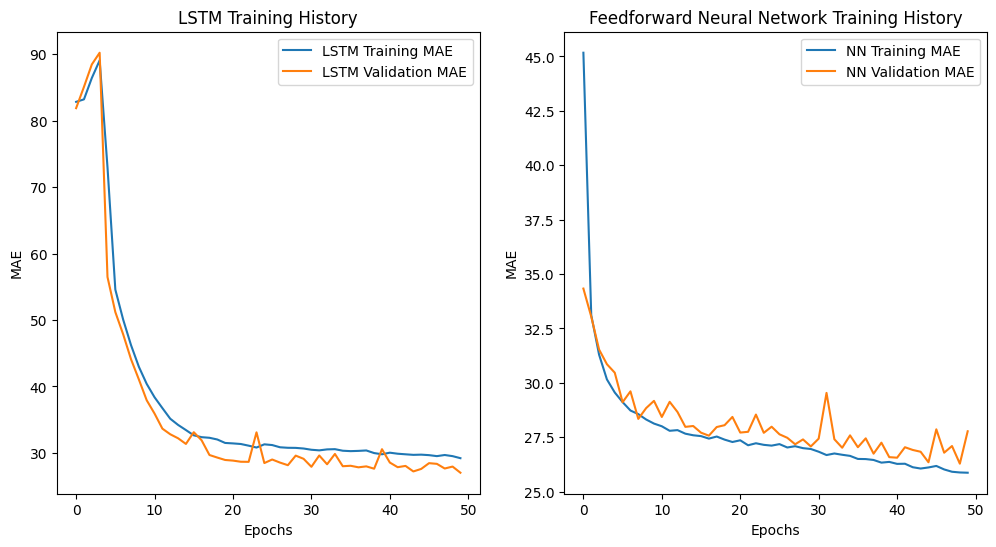

In [24]:
# Plot LSTM and Feedforward Neural Network training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['mae'], label='LSTM Training MAE')
plt.plot(history_lstm.history['val_mae'], label='LSTM Validation MAE')
plt.title('LSTM Training History')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_nn.history['mae'], label='NN Training MAE')
plt.plot(history_nn.history['val_mae'], label='NN Validation MAE')
plt.title('Feedforward Neural Network Training History')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [25]:
# Model 6: Pre-training with Black-Scholes predicted prices as input
X_bs_pretrain = np.column_stack((X, bs_option_prices))

# Split into training and validation sets for pre-training
X_train_bs, X_val_bs, y_train_bs, y_val_bs = train_test_split(X_bs_pretrain, y, test_size=0.2, random_state=42)

# Train the deep learning model with pre-training
model_pretrain = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_bs.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])
model_pretrain.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mae'])
model_pretrain.fit(X_train_bs, y_train_bs, epochs=50, batch_size=16, validation_data=(X_val_bs, y_val_bs), verbose=1)

# Final evaluation with pre-training
y_pred_pretrain = model_pretrain.predict(X_val_bs)
evaluate_model(y_val_bs, y_pred_pretrain, "Deep Learning with Pre-Training")

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1154/1154 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 4736.3052 - mae: 38.0121 - val_loss: 3519.8420 - val_mae: 29.1256
Epoch 2/50
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3365.7744 - mae: 31.3041 - val_loss: 3450.0933 - val_mae: 28.7568
Epoch 3/50
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 3151.3955 - mae: 30.6931 - val_loss: 3113.9836 - val_mae: 31.9683
Epoch 4/50
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3054.6184 - mae: 30.4852 - val_loss: 3083.8777 - val_mae: 32.3219
Epoch 5/50
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 3099.5332 - mae: 30.7575 - val_loss: 3063.4048 - val_mae: 31.6958
Epoch 6/50
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3061.6035 - mae: 30.6448 - val_loss: 3034.0925 - val_mae: 28.4939
Epoch 7/50
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 3033.3452 - mae: 30.2056 - val_loss: 2981.1921 - val_mae: 31.7785
Epoch 8/50
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 2850.9009 - mae: 29.3559 - val_loss: 2866.5886 - val_

In [26]:
# Model 7: Error Correcting Model
errors = y_val - y_pred_nn

# Train an error-correcting model
error_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])

error_model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mae'])
error_model.fit(X_val, errors, epochs=50, batch_size=16, validation_split=0.2, verbose=1)

# Make predictions with the error-correcting model
error_predictions = error_model.predict(X_val)

# Combine base model predictions with error corrections
y_pred_corrected = y_pred_nn + error_predictions

# Evaluate the error-correcting model
evaluate_model(y_val, y_pred_corrected, "Error-Correcting Model")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 21919.8184 - mae: 107.2308 - val_loss: 16499.4512 - val_mae: 100.2790
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 15216.9805 - mae: 97.9969 - val_loss: 13942.0000 - val_mae: 93.8509
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 13841.2080 - mae: 93.4253 - val_loss: 13496.7295 - val_mae: 93.2875
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 13590.4502 - mae: 93.1673 - val_loss: 13332.4531 - val_mae: 93.3871
Epoch 5/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 13469.1240 - mae: 92.9365 - val_loss: 13240.1260 - val_mae: 92.5807
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 13426.5830 - mae: 92.7822 - val_loss: 13179.5039 - val_mae: 92.3892
Epoch 7/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 13314.0254 - mae: 92.3321 - val_loss: 13131.3486 - val_mae: 92.1896
Epoch 8/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 13331.9570 - mae: 92.4363 - val_loss: 1311

## Financial Model Evaluation

### 1. Out-of-the-Money (OTM) vs In-the-Money (ITM) Pricing Accuracy

In [27]:
# Out-of-the-Money (OTM) vs In-the-Money (ITM) Pricing Accuracy
def evaluate_otm_itm_accuracy(model_name,X_test, y_true, y_pred, strike_col, price_col):
    itm_mask = X_test[:, price_col] > X_test[:, strike_col]  # ITM condition
    otm_mask = X_test[:, strike_col] > X_test[:, price_col]  # OTM condition

    # ITM Pricing
    y_true_itm = y_true[itm_mask]
    y_pred_itm = y_pred[itm_mask]
    print("\nIn-the-Money (ITM) Accuracy:")
    evaluate_model(y_true_itm, y_pred_itm, model_name)

    # OTM Pricing
    y_true_otm = y_true[otm_mask]
    y_pred_otm = y_pred[otm_mask]
    print("\nOut-of-the-Money (OTM) Accuracy:")
    evaluate_model(y_true_otm, y_pred_otm, model_name)




In [28]:
evaluate_otm_itm_accuracy("Random Forest",X_val, y_val, y_pred_rf, strike_col=2, price_col=1)


In-the-Money (ITM) Accuracy:
Random Forest
------------------------------
Mean Absolute Error (MAE): 6.5677
Root Mean Squared Error (RMSE): 16.8008
R-Squared (R²): 0.7337 


Out-of-the-Money (OTM) Accuracy:
Random Forest
------------------------------
Mean Absolute Error (MAE): 16.8360
Root Mean Squared Error (RMSE): 36.4477
R-Squared (R²): 0.9131 



In [29]:
evaluate_otm_itm_accuracy("XGBoost",X_val, y_val, y_pred_xgb, strike_col=2, price_col=1)


In-the-Money (ITM) Accuracy:
XGBoost
------------------------------
Mean Absolute Error (MAE): 9.1249
Root Mean Squared Error (RMSE): 18.6025
R-Squared (R²): 0.6736 


Out-of-the-Money (OTM) Accuracy:
XGBoost
------------------------------
Mean Absolute Error (MAE): 28.2893
Root Mean Squared Error (RMSE): 47.0539
R-Squared (R²): 0.8551 



In [30]:
evaluate_otm_itm_accuracy("SVR",X_val, y_val, y_pred_svr, strike_col=2, price_col=1)


In-the-Money (ITM) Accuracy:
SVR
------------------------------
Mean Absolute Error (MAE): 12.2368
Root Mean Squared Error (RMSE): 28.9819
R-Squared (R²): 0.2076 


Out-of-the-Money (OTM) Accuracy:
SVR
------------------------------
Mean Absolute Error (MAE): 45.5332
Root Mean Squared Error (RMSE): 83.5064
R-Squared (R²): 0.5438 



In [31]:
evaluate_otm_itm_accuracy("Standard Deep Learning",X_val, y_val, y_pred_nn, strike_col=2, price_col=1)


In-the-Money (ITM) Accuracy:
Standard Deep Learning
------------------------------
Mean Absolute Error (MAE): 13.4946
Root Mean Squared Error (RMSE): 23.8572
R-Squared (R²): 0.4631 


Out-of-the-Money (OTM) Accuracy:
Standard Deep Learning
------------------------------
Mean Absolute Error (MAE): 48.6669
Root Mean Squared Error (RMSE): 71.6365
R-Squared (R²): 0.6642 



In [32]:
evaluate_otm_itm_accuracy("LSTM",X_val, y_val, y_pred_lstm, strike_col=2, price_col=1)


In-the-Money (ITM) Accuracy:
LSTM
------------------------------
Mean Absolute Error (MAE): 14.1688
Root Mean Squared Error (RMSE): 24.0890
R-Squared (R²): 0.4526 


Out-of-the-Money (OTM) Accuracy:
LSTM
------------------------------
Mean Absolute Error (MAE): 45.7986
Root Mean Squared Error (RMSE): 70.0444
R-Squared (R²): 0.6790 



In [33]:
evaluate_otm_itm_accuracy("Deep Learning with Pre-Training",X_val, y_val, y_pred_pretrain, strike_col=2, price_col=1)


In-the-Money (ITM) Accuracy:
Deep Learning with Pre-Training
------------------------------
Mean Absolute Error (MAE): 11.9402
Root Mean Squared Error (RMSE): 23.9878
R-Squared (R²): 0.4572 


Out-of-the-Money (OTM) Accuracy:
Deep Learning with Pre-Training
------------------------------
Mean Absolute Error (MAE): 49.0564
Root Mean Squared Error (RMSE): 73.5355
R-Squared (R²): 0.6462 



In [34]:
# Evaluate the error-correcting model
evaluate_otm_itm_accuracy("Error-Correcting Model",X_val, y_val, y_pred_corrected, strike_col=2, price_col=1)


In-the-Money (ITM) Accuracy:
Error-Correcting Model
------------------------------
Mean Absolute Error (MAE): 65.7470
Root Mean Squared Error (RMSE): 69.7609
R-Squared (R²): -3.5908 


Out-of-the-Money (OTM) Accuracy:
Error-Correcting Model
------------------------------
Mean Absolute Error (MAE): 122.8612
Root Mean Squared Error (RMSE): 151.0569
R-Squared (R²): -0.4929 



### 2. Pricing Bias Analysis

In [35]:
# Pricing Bias Analysis
def check_pricing_bias(model_name,X_test, y_true, y_pred, strike_col, price_col):
    strike_prices = X_test[:, strike_col]
    underlying_prices = X_test[:, price_col]

    # Store strike prices and average bias for plotting
    unique_strikes = np.unique(strike_prices)
    avg_bias_per_strike = []

    # Calculate bias: predicted - actual
    bias = y_pred - y_true

    for strike in np.unique(strike_prices):
        mask = (strike_prices == strike)
        avg_bias = np.mean(bias[mask])
        avg_bias_per_strike.append(avg_bias)
        #print(f"Strike Price {strike}: Average Bias = {avg_bias:.4f}")

    # Plotting the scatter chart
    plt.figure(figsize=(10, 6))
    plt.scatter(unique_strikes, avg_bias_per_strike, color='blue', label='Pricing Bias', alpha=0.7)

    # Labels and title
    plt.xlabel('Strike Price')
    plt.ylabel('Average Pricing Bias (Predicted - Actual)')
    plt.title(f'Pricing Bias Analysis (Scatter Plot) for {model_name}')
    plt.grid(True)
    plt.legend()

    # Show the plot
    plt.show()

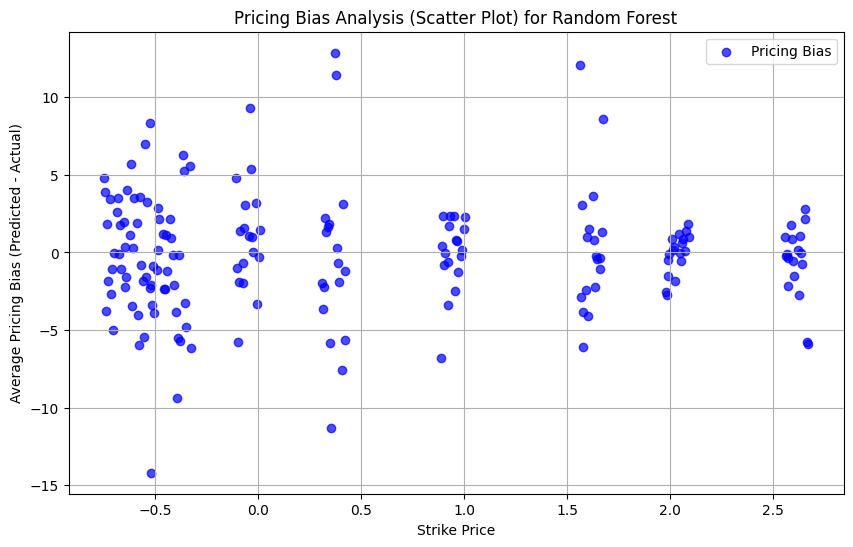

In [36]:
check_pricing_bias("Random Forest",X_val, y_val, y_pred_rf, strike_col=2, price_col=1)

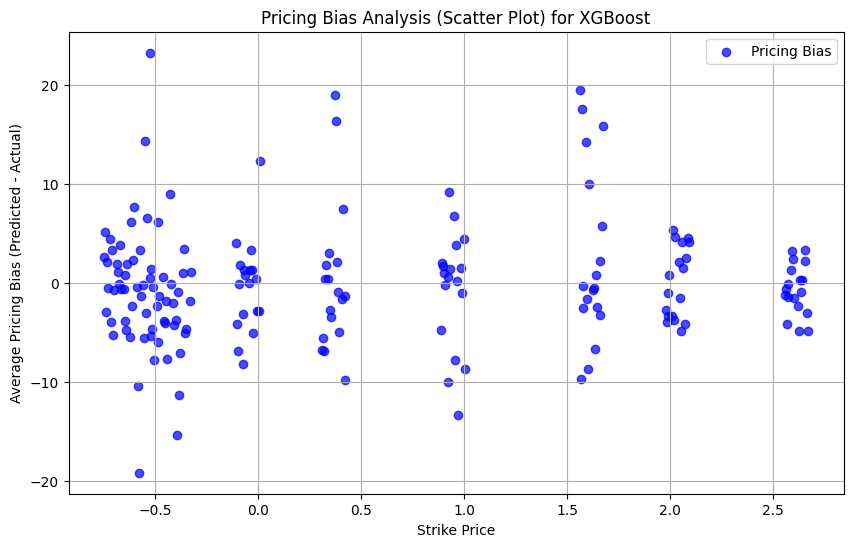

In [37]:
check_pricing_bias("XGBoost",X_val, y_val, y_pred_xgb, strike_col=2, price_col=1)

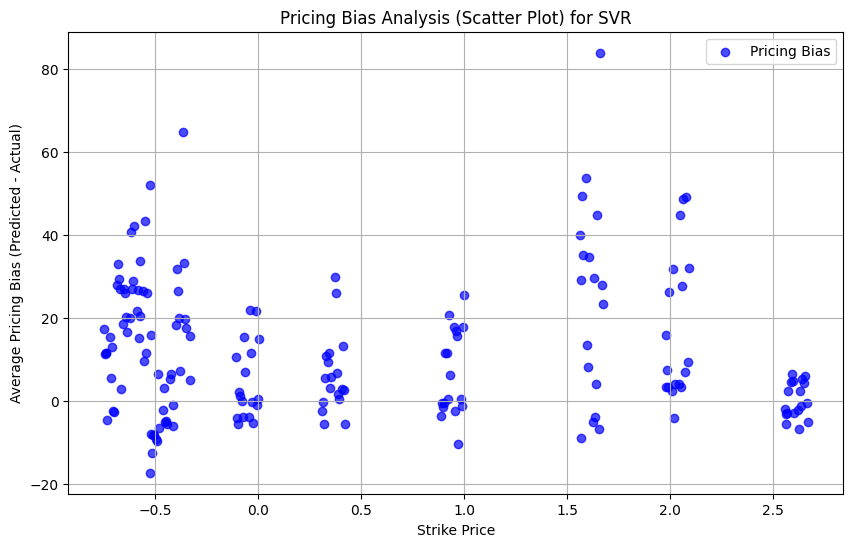

In [38]:
check_pricing_bias("SVR",X_val, y_val, y_pred_svr, strike_col=2, price_col=1)

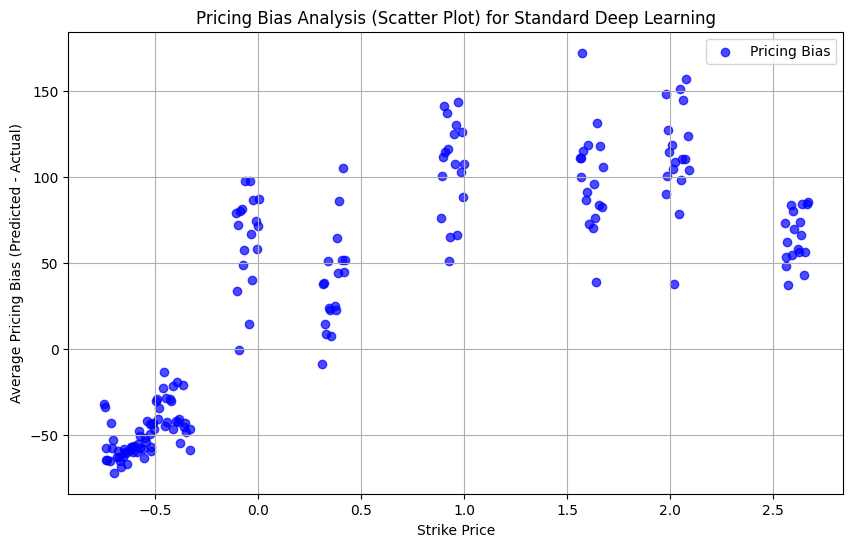

In [39]:
check_pricing_bias("Standard Deep Learning",X_val, y_val, y_pred_nn, strike_col=2, price_col=1)

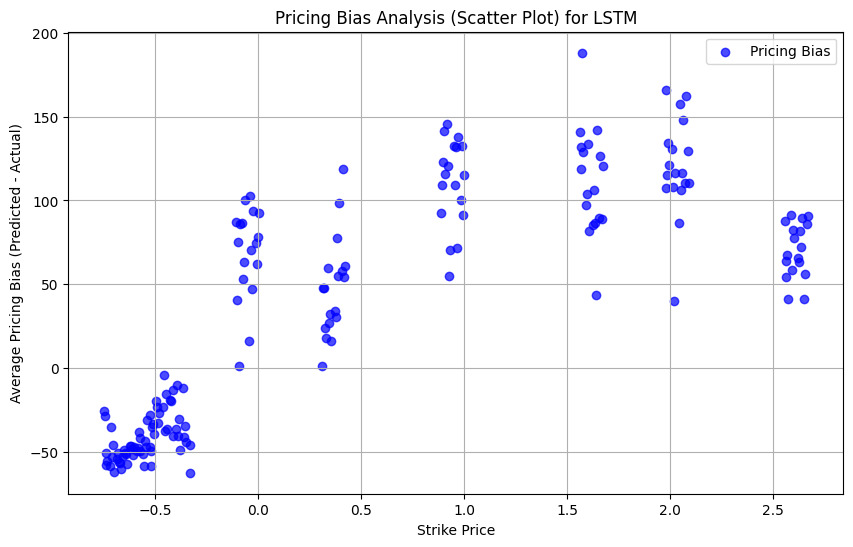

In [40]:
check_pricing_bias("LSTM",X_val, y_val, y_pred_lstm, strike_col=2, price_col=1)

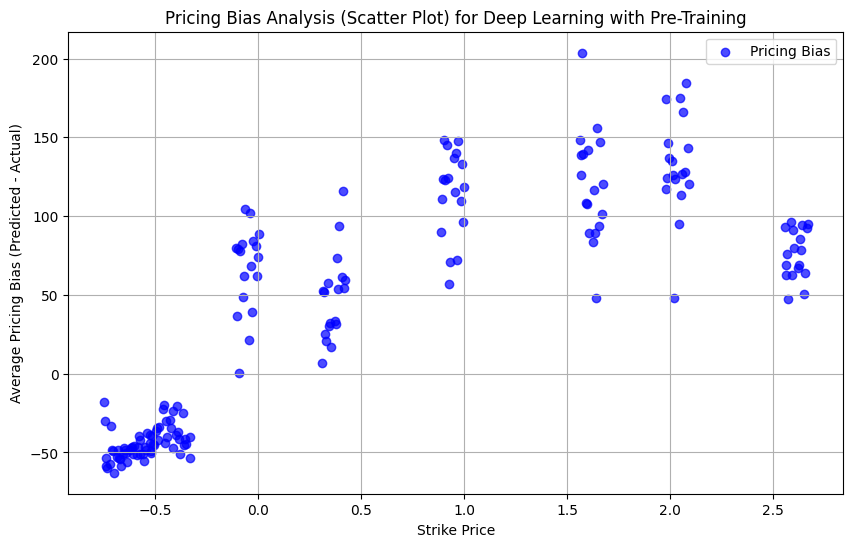

In [41]:
check_pricing_bias("Deep Learning with Pre-Training",X_val, y_val, y_pred_pretrain, strike_col=2, price_col=1)

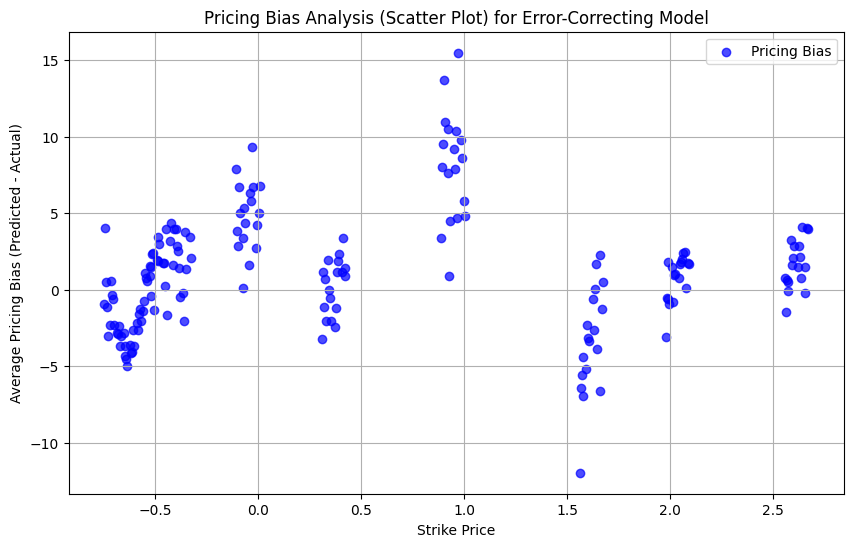

In [42]:
check_pricing_bias("Error-Correcting Model",X_val, y_val, y_pred_corrected, strike_col=2, price_col=1)